## Time series project: anomaly detection

In [2]:
pip install -r ../requirements.txt


[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from pmdarima.arima import auto_arima
from pylab import rcParams

In [4]:
# Read data

df_raw_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-a.csv')
df_raw_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-b.csv')


test_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-a.csv')
test_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-b.csv')

In [5]:
df_raw_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  420 non-null    object 
 1   cpu       420 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB


In [6]:
df_raw_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  600 non-null    object 
 1   cpu       600 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB


In [7]:
df_raw_a

,datetime,cpu
0,2017-01-27 18:42:00,1.14
1,2017-01-27 18:43:00,1.10
2,2017-01-27 18:44:00,1.09
3,2017-01-27 18:45:00,1.08
4,2017-01-27 18:46:00,1.08
...,...,...
415,2017-01-28 01:37:00,2.41
416,2017-01-28 01:38:00,2.16
417,2017-01-28 01:39:00,1.93
418,2017-01-28 01:40:00,2.14


In [8]:
# Change variable type

df_interim_a = df_raw_a.copy()
df_interim_b = df_raw_b.copy()

df_interim_a['datetime'] = pd.to_datetime(df_interim_a['datetime'])
df_interim_b['datetime'] = pd.to_datetime(df_interim_b['datetime'])

In [9]:
# Change variable type - test data

test_a['datetime'] = pd.to_datetime(test_a['datetime'])
test_b['datetime'] = pd.to_datetime(test_b['datetime'])

In [10]:
# Set time as index because we are working with time series

df_interim_a = df_interim_a.set_index(df_interim_a['datetime'])
df_interim_b = df_interim_b.set_index(df_interim_b['datetime'])

test_a = test_a.set_index(test_a['datetime'])
test_b = test_b.set_index(test_b['datetime'])

In [11]:
df_interim_a

,datetime,cpu
datetime,,
2017-01-27 18:42:00,2017-01-27 18:42:00,1.14
2017-01-27 18:43:00,2017-01-27 18:43:00,1.10
2017-01-27 18:44:00,2017-01-27 18:44:00,1.09
2017-01-27 18:45:00,2017-01-27 18:45:00,1.08
2017-01-27 18:46:00,2017-01-27 18:46:00,1.08
...,...,...
2017-01-28 01:37:00,2017-01-28 01:37:00,2.41
2017-01-28 01:38:00,2017-01-28 01:38:00,2.16
2017-01-28 01:39:00,2017-01-28 01:39:00,1.93


In [12]:
df_interim_a

,datetime,cpu
datetime,,
2017-01-27 18:42:00,2017-01-27 18:42:00,1.14
2017-01-27 18:43:00,2017-01-27 18:43:00,1.10
2017-01-27 18:44:00,2017-01-27 18:44:00,1.09
2017-01-27 18:45:00,2017-01-27 18:45:00,1.08
2017-01-27 18:46:00,2017-01-27 18:46:00,1.08
...,...,...
2017-01-28 01:37:00,2017-01-28 01:37:00,2.41
2017-01-28 01:38:00,2017-01-28 01:38:00,2.16
2017-01-28 01:39:00,2017-01-28 01:39:00,1.93


In [13]:
df_interim_a.describe(datetime_is_numeric=True)

,datetime,cpu
count,420,420.000000
mean,2017-01-27 22:11:29.999999744,1.233262
min,2017-01-27 18:42:00,0.570000
25%,2017-01-27 20:26:45,0.787500
50%,2017-01-27 22:11:30,1.110000
75%,2017-01-27 23:56:15,1.582500
max,2017-01-28 01:41:00,2.550000
std,NaN,0.505668


In [14]:
df_interim_b.describe(datetime_is_numeric=True)

,datetime,cpu
count,600,600.000000
mean,2017-01-27 23:41:30,1.282733
min,2017-01-27 18:42:00,0.570000
25%,2017-01-27 21:11:45,0.840000
50%,2017-01-27 23:41:30,1.240000
75%,2017-01-28 02:11:15,1.610000
max,2017-01-28 04:41:00,2.550000
std,NaN,0.484951


In [15]:
test_a.describe(datetime_is_numeric=True)

,datetime,cpu
count,60,60.000000
mean,2017-01-28 02:11:29.999999744,1.271500
min,2017-01-28 01:42:00,0.680000
25%,2017-01-28 01:56:45,0.902500
50%,2017-01-28 02:11:30,1.210000
75%,2017-01-28 02:26:15,1.562500
max,2017-01-28 02:41:00,2.190000
std,NaN,0.418309


In [16]:
test_b.describe(datetime_is_numeric=True)

,datetime,cpu
count,60,60.000000
mean,2017-01-28 05:11:30,1.345833
min,2017-01-28 04:42:00,0.030000
25%,2017-01-28 04:56:45,0.070000
50%,2017-01-28 05:11:30,1.605000
75%,2017-01-28 05:26:15,2.150000
max,2017-01-28 05:41:00,2.830000
std,NaN,0.954620


- The dataframes contain data for every minute about CPU usage
- df_interim_a has data between 18.42 and 1.41 (from the next day) and df_interim_b has data between 18.42 and 4.41 (from the same days as df_interim_a)
- So, df_interim_b is an extension of df_interim_a
- The test set, both a and b, contain informatio about the 60 minutes that follow the end of the train datasets

In [17]:
# Drop variables

df_interim_a = df_interim_a.drop('datetime', axis=1)
df_interim_b = df_interim_b.drop('datetime', axis=1)

In [18]:
test_a = test_a.drop('datetime', axis=1)
test_b = test_b.drop('datetime', axis=1)

In [19]:
df_a = df_interim_a.copy()
df_b = df_interim_b.copy()

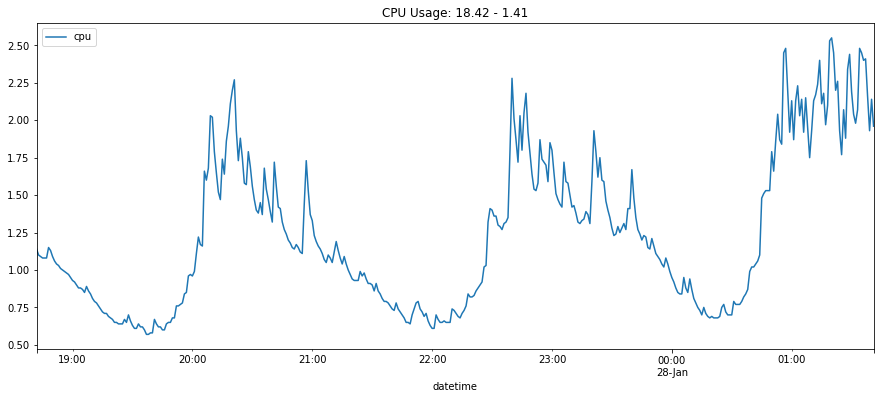

In [20]:
df_a.plot(title="CPU Usage: 18.42 - 1.41", figsize=(15,6))
plt.show()

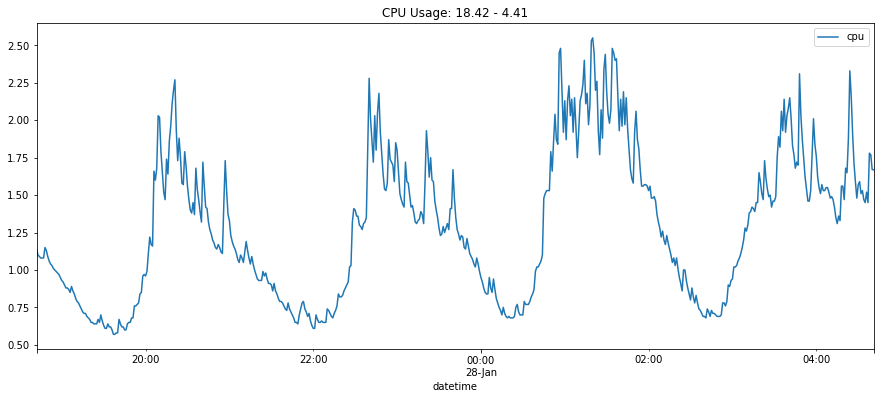

In [21]:
df_b.plot(title="CPU Usage: 18.42 - 4.41", figsize=(15,6))
plt.show()

- There seems to be a seasonal component very two hours. Below we will perform a decomposition analysis.

In [22]:
df_a

,cpu
datetime,
2017-01-27 18:42:00,1.14
2017-01-27 18:43:00,1.10
2017-01-27 18:44:00,1.09
2017-01-27 18:45:00,1.08
2017-01-27 18:46:00,1.08
...,...
2017-01-28 01:37:00,2.41
2017-01-28 01:38:00,2.16
2017-01-28 01:39:00,1.93


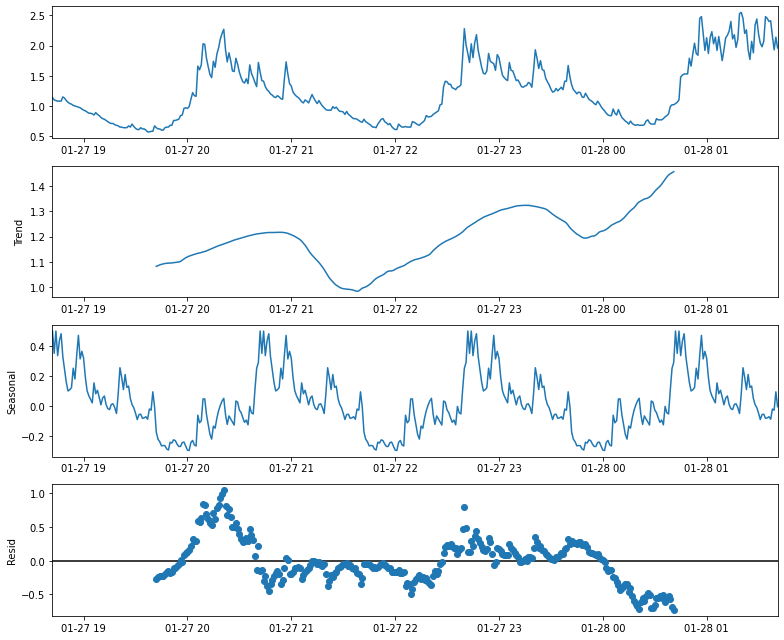

In [23]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(df_a,model='additive',period=60*2) # 2 hours period, the datetime is in minutes
fig = decomposition.plot()
plt.show()

- Given the seasonality of the data we will use a Seasonal ARIMA model (SARIMA)
- We have to choose the parameters p, d, q for the ARIMA and P, D, Q for the seasonal component

**Step 4:**
Use SARIMA model to fit the data

In [24]:
stepwise_model = auto_arima(df_a, start_p=1, start_q=1,
                           max_p=1, max_q=1, m=60*2,
                           start_P=0, seasonal=True,
                           d=1, D=1,max_P=1,max_Q=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,random_state=608)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[120]             : AIC=inf, Time=991.87 sec
 ARIMA(0,1,0)(0,1,0)[120]             : AIC=-187.268, Time=30.68 sec


In [ ]:
# Fit the best model

stepwise_model.fit(df_a)

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

**Step 5:**
Evaluate the performance

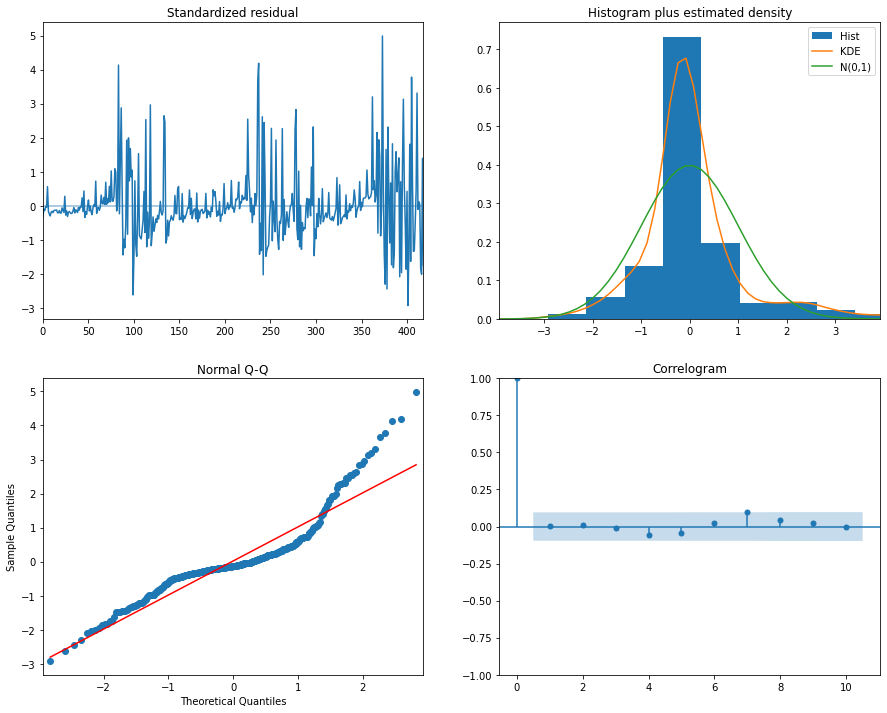

In [ ]:
stepwise_model.fit(df_a).plot_diagnostics(figsize=(15, 12))
plt.show()

- There seems to be autocorrelation in the residual and the distribution does not seem to be Normal.
- We colud try with other values for the parameters p, d, q and P, D, Q. Because of the high frequency of the data the model takes a lot time to run.

In [ ]:
# Predict values in the test set

forecast_a = stepwise_model.predict(n_periods=60)

**Step 6:**
- 6.1 Actual followed predicted values
- 6.2 Actual compared to predicted values

In [ ]:
forecast_a = pd.DataFrame(forecast_a,index = test_a.index,columns=['Prediction'])
pd.concat([df_a.tail(100),forecast_a],axis=0).plot(title='Actual followed by predicted values')

- The CPU usage predicted shows a decrease around 2 am given the seasonal component of the data adn the it starts to increase around 3 am

In [ ]:
pd.concat([test_a,forecast_a],axis=1).plot(title='Actual value compared to predicted value')

- But this is not what we see in the actual values, that present a downward trend until the end of the hour

Save model as pickle

In [ ]:
filename = '../models/model_a.pkl'
pickle.dump(stepwise_model, open(filename,'wb'))

**Step 7:** Anomaly detection using df_b

In [ ]:
stepwise_model.fit(df_b)
forecast_b = stepwise_model.predict(n_periods=60)

In [ ]:
stepwise_model.fit(df_b).plot_diagnostics(figsize=(15, 12))
plt.show()

- Again, with this dataset we see that the residuals are problematic
- We should improve our model, with more lags of the components ar, ma, sar or sma

In [ ]:
forecast_b = pd.DataFrame(forecast_b,index = test_b.index,columns=['Prediction'])
pd.concat([test_b,forecast_b],axis=1).plot(title='Actual values compared to predicted values')

- The actual value of the CPU usage has a strong decrease around 5 am that cannot be predicted by the model, since it seems to be an outlier
- After 5.15 am the model starts to predict a little bit better
- Despite of this, the model needs to be improved given that the residuals do not meet the assumptions of an ARIMA model

Save model as pickle

In [ ]:
filename = '../models/model_b.pkl'
pickle.dump(stepwise_model, open(filename,'wb'))